# DBSCAN
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a popular clustering algorithm known for its effectiveness in identifying clusters of varying shapes and sizes in a data set. It is particularly adept at handling noise and outliers, making it a great choice for real-world data clustering tasks.

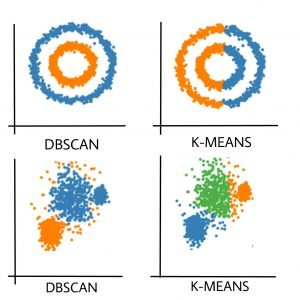

## Key Features of DBSCAN
- Density-based: Unlike centroid-based algorithms like k-means, DBSCAN groups together points that are closely packed together, marking as outliers the points that lie alone in low-density regions.

- No Need to Specify Cluster Numbers: DBSCAN does not require the user to specify the number of clusters in advance, which sets it apart from many other clustering algorithms.

- Ability to Find Arbitrarily Shaped Clusters: DBSCAN can find non-linearly separable clusters that other algorithms often fail to detect.

## How DBSCAN Works

DBSCAN classifies data points into three types based on the neighborhood density:

- Core Points: A point is a core point if at least a minimum number of other points (defined by min_samples) lie within a radius (eps) of it.

- Border Points: A point is a border point if it is not a core point itself but lies within the radius of a core point.

- Noise Points: Every other point that is not a core or border point.


### The Algorithm Steps:
1. Identify Core Points: For each point in the dataset, count how many points fall within the eps distance. If this count exceeds min_samples, label it as a core point.

2. Expand Clusters: For each core point, if it is not already assigned to a cluster, create a new cluster, then recursively add all directly density-reachable points to this cluster.

3. Assign Border Points: Assign each border point to one of the clusters of its associated core points.
4. Mark Noise: Every point not assigned to a cluster is noise.

## Pros and Cons of DBSCAN
### Pros:

- Effective at dealing with noise and outliers.

- Capable of identifying clusters of arbitrary shapes and sizes.

- Only two parameters (eps and min_samples) need to be set.

### Cons:

- Sensitive to the setting of eps and min_samples. Inappropriate values can yield poor clustering results.

- Not well-suited for clustering datasets with varying densities, as a single eps might not suit all clusters.

- Higher dimensional data can diminish its performance, often referred to as the "curse of dimensionality."

## Application

We will first implement dbscan on the Breast Cancer Dataset, which has over 30 features.

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [53]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

X = X.values
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = y.values
y = np.where(y == 'B', 0, 1)
y = y.ravel()

We need to figure out how many eps work best for this dataset. We will do this by finding a value that is a good balance between too far and too close. This value is usually called the 'elbow'.

In [54]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Initialize and fit NearestNeighbors to find the two closest points for each point in X.
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(X)

# Retrieve and sort the distances of the nearest non-self neighbors for each point in X.
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances[:, 1])


In [55]:
from kneed import KneeLocator

# Use KneeLocator to find the knee point of the sorted distances which helps in determining the optimal eps.
knee = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')

# Retrieve the optimal eps value from the distances array using the index of the knee.
optimal_eps = distances[knee.knee]
print(f"Optimal eps value: {optimal_eps}")

Optimal eps value: 5.256832680328551


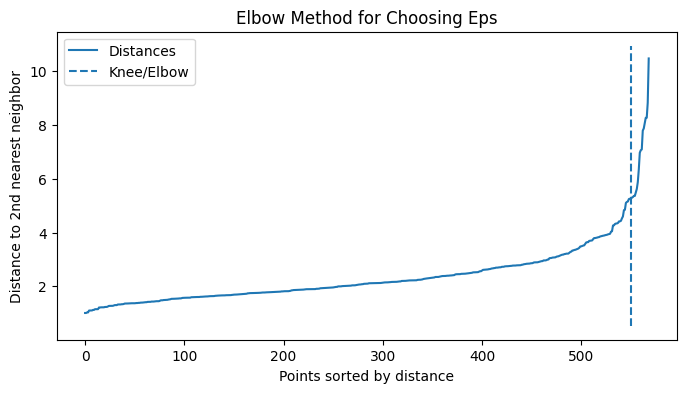

In [56]:
import matplotlib.pyplot as plt
# elbow plot
plt.figure(figsize=(8, 4))
plt.plot(range(len(distances)), distances, label='Distances')
plt.vlines(knee.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', label='Knee/Elbow')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to 2nd nearest neighbor')
plt.title('Elbow Method for Choosing Eps')
plt.legend()
plt.show()

We can see here that at eps euqals ~ 5, we find a good balance between too far and too close. Let's implement dbscan with this value.

In [57]:
# Apply DBSCAN clustering to dataset X.
dbscan = DBSCAN(eps=5, min_samples=5)
clusters = dbscan.fit_predict(X)

# Calculate the number of clusters, excluding noise points.
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

# Output the results.
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 24


Our model tells us our data fit together in one cluster, with only 24 noise points. One cluster is relatively uncommon and could be due to a number of factors. One possibility is a relatively uniform distribution of data points across the feature space of the Breast Cancer Dataset. Another possibility is we made the requirements for a point to join the cluster to broad/easy. Let's visualize what our cluster looks like.

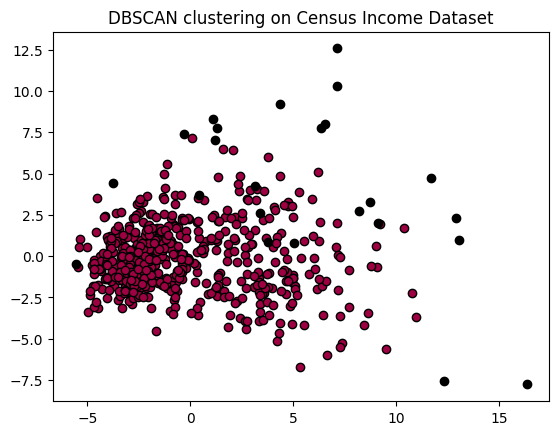

In [58]:
from sklearn.decomposition import PCA

# Apply PCA to reduce the dataset to 2 dimensions for visualization.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Identify unique cluster labels.
unique_labels = set(clusters)

# Generate a color map for each cluster label.
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

# Plot each cluster with its assigned color.
for k, col in zip(unique_labels, colors):
    if k == -1:  # Color noise points as black.
        col = [0, 0, 0, 1]
    class_member_mask = (clusters == k)
    xy = X_pca[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('DBSCAN clustering on Census Income Dataset')
plt.show()


We can see that the data points are pretty close together, with the noise in black. Maybe the min_samples value is too low. Let's see what happens when we test different values.

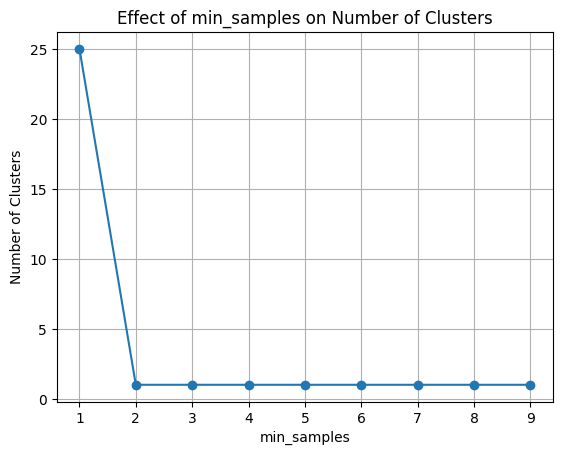

In [59]:
results = {}
for min_samples in range(1, 10):
    dbscan = DBSCAN(eps=5, min_samples=min_samples)
    clusters = dbscan.fit_predict(X)
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    results[min_samples] = n_clusters

# Plotting the number of clusters for each min_samples value
plt.plot(list(results.keys()), list(results.values()), marker='o')
plt.xlabel('min_samples')
plt.ylabel('Number of Clusters')
plt.title('Effect of min_samples on Number of Clusters')
plt.grid(True)
plt.show()


Here we can see that the value for min_samples is irrelevant to the number of clusters. What we can infer is that there's not enough diversity in the feature values to form distinct groups. We will implement dbscan again, this time on the Wine Quality dataset, where the features are very different.

In [60]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 
  
X = X.values
y = y.values



In [61]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

neighbors = NearestNeighbors(n_neighbors=2
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Sort the distances
distances = np.sort(distances[:, 1])

from kneed import KneeLocator
knee = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
optimal_eps = distances[knee.knee]
print(f"Optimal eps value: {optimal_eps}")


Optimal eps value: 8.191960460939738


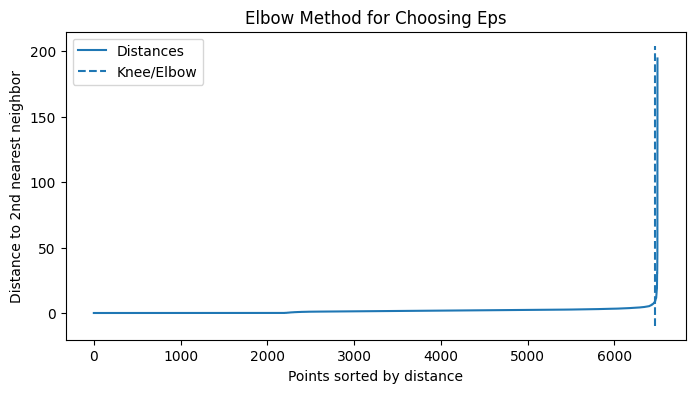

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(range(len(distances)), distances, label='Distances')
plt.vlines(knee.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', label='Knee/Elbow')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to 2nd nearest neighbor')
plt.title('Elbow Method for Choosing Eps')
plt.legend()
plt.show()

In [63]:
dbscan = DBSCAN(eps=8, min_samples=5)
clusters = dbscan.fit_predict(X)

n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


Estimated number of clusters: 3
Estimated number of noise points: 84


When we set our eps = 8 and min_samples = 5, we get three clusters and 84 noise points. This is a pretty good result, but I don't like the number of noise points. Let's see what happens when we increase the value for min_samples.

In [70]:
dbscan = DBSCAN(eps=8, min_samples=3)
clusters = dbscan.fit_predict(X)

n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 6
Estimated number of noise points: 66


Interesting, when we lower the value for min_samples the number of clusters skyrockets, but we get less noise points. Let's visualize how the number for clusters changes with the value of min_samples.

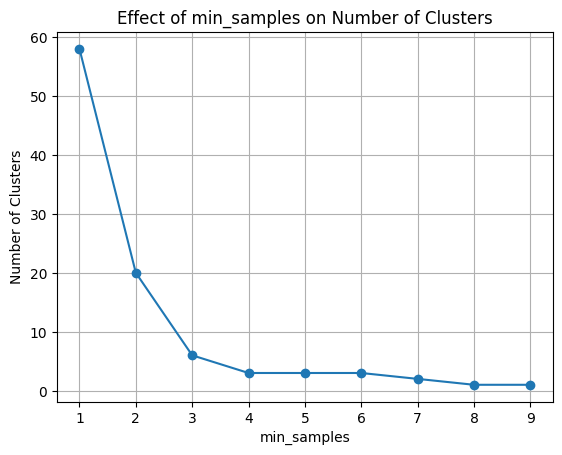

In [65]:
results = {}
for min_samples in range(1, 10):
    dbscan = DBSCAN(eps=8, min_samples=min_samples)
    clusters = dbscan.fit_predict(X)
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    results[min_samples] = n_clusters

plt.plot(list(results.keys()), list(results.values()), marker='o')
plt.xlabel('min_samples')
plt.ylabel('Number of Clusters')
plt.title('Effect of min_samples on Number of Clusters')
plt.grid(True)
plt.show()


If your goal is to identify clear, dense groups within the data, you might prefer more distinct clusters and fewer noise points. If your focus is on identifying outliers or anomalies in the dataset, having more noise points can be beneficial.

Depending on your goal, you can change the value of eps and min_samples within dbscan.